In [65]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from keras import backend as K 
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import random
import os
from glob import glob
import time



from zipfile import ZipFile
import scipy.io
from PIL import Image, ImageDraw, ImageEnhance


%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 


import imageio
import pandas as pd
import numpy as np
import re

import shutil

In [ ]:
from PIL import Image
import glob
image_size = 225
img_list = []
labels = []
boxes=[]
xmin = []
ymin = []
xmax = []
ymax = []
width_height=[]

for filename in glob.glob('C:/Users/gorya/OneDrive/Desktop/TZ/cats_dogs_dataset/*.jpg'): 
    im = Image.open(filename)
    width_height.append(im.size)
    img  = cv2.imread(filename)

# Resize all images to a fix size
    image = cv2.resize(img, (image_size, image_size))
    

# Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

# Normalize the image by dividing it by 255.0 
    image = image.astype("float") / 255.0

# Append it to the list of images
    img_list.append(image)



In [ ]:

files = glob.glob('C:/Users/gorya/OneDrive/Desktop/TZ/cats_dogs_dataset/*.txt')
for file in files: 
    with open(file, 'r') as f:
        result = f.read()
    boxes.append(result)
df=pd.DataFrame(columns = ["xmin","ymin","xmax", "ymax"], dtype=object)
labels = [ele.split(' ')[0] for ele in boxes]
labels = list(map(int, labels))
df["xmin"] = [ele.split(' ')[1] for ele in boxes]
df["xmin"] = list(map(int, df["xmin"]))
df["ymin"] = [ele.split(' ')[2] for ele in boxes]
df["ymin"] = list(map(int, df["ymin"]))
df["xmax"] = [ele.split(' ')[3] for ele in boxes]
df["xmax"] = list(map(int, df["xmax"]))
df["ymax"] = [ele.split(' ')[4] for ele in boxes]
df["ymax"] = list(map(int, df["ymax"]))
h=[]
w=[]
boxes=[]


print(df.iloc[0])
for a_tuple in width_height:
    h.append(a_tuple[1])
    w.append(a_tuple[0])
for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h),list(df['xmax']/w), list(df['ymax']/h)):
    
    arr = [x1, y1, x2, y2]
    boxes.append(arr)
print(boxes[0])

In [ ]:
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)
random_range = random.sample(range(1, len(img_list)), 20)

for iteration, i in enumerate(random_range, 1):
# Rescaling the boundig box values to match the image size
    image = img_list[i]    
    boxes[i][0] = boxes[i][0] * image_size
    boxes[i][1] = boxes[i][1] * image_size
    boxes[i][2] = boxes[i][2] * image_size
    boxes[i][3] = boxes[i][3] * image_size

# The image to visualize
    image = img_list[i]
    
# Draw bounding boxes on the image
    cv2.rectangle(image, (int(boxes[i][0]), int(boxes[i][1])),(int(boxes[i][2]), int(boxes[i][3])),(0,255,0),4);
   
    
# Clip the values to 0-1 and draw the sample of images
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(image);



In [ ]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size = 0.1,random_state = 43)

print('Total Training Images: {}, Total Test Images: {}'.format(
    len(train_images), 
    len(val_images)
    ))

In [ ]:
# Load the NasNetMobile Model
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet'
    )

In [ ]:
# function that construct the model
def create_model(no_of_classes):

    # Freeze the whole model
    N_mobile.trainable = False
    
    # Start by taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output
    
    # Convert to a single-dimensional vector
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Create Classification Head, final layer contains 
    # Ouput units = no. classes
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',name="class_output")(class_prediction)

    # Create Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(32, activation="relu")(box_output)
    box_output = Dense(16, activation="relu")(box_output)
    
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # combine the two heads
    model = Model(inputs=N_mobile.input, outputs= [box_predictions, class_prediction])

    return model

# Create the model for 2 classes
model = create_model(2)
print("Model Created")

In [ ]:
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }


loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = SGD(lr = 1e-2, momentum = 0.9)
# Compile the model
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

In [ ]:
# Train the Model
history = model.fit(x = train_images, 
                    y= {
                        "box_output": train_boxes, 
                        "class_output": train_labels
                        }, 
                    validation_data=(
                        val_images, 
                        {
                          "box_output": val_boxes, 
                          "class_output": val_labels
                          }), batch_size = 32, epochs = 2, 
                    callbacks=[reduce_lr, stop])

In [62]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 225, 225, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 112, 112, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [ ]:
ls saved_model

In [ ]:

global label_names
label_names = np.unique(labels)
print(label_names)

In [81]:
#  function to make prediction on images.

def predict(image, x_1, y_1, x_2, y_2, returnimage = False,  scale = 0.9):
  
  #  preprocess the image.
    processed_image = preprocess(image)

  #  prediction
    results = model.predict(processed_image)

  #  postprocess .
    label, (x1, y1, x2, y2), confidence = postprocess(image, results)
    thistuple = (label, [x1, y1, x2, y2])
    print(f"the prediced class and bounding box {thistuple}")
    
    xA = max(x_1, x1)
    yA = max(y_1, y1)
    xB = min(x_2, x2)
    yB = min(y_2, y2)
    
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (x_2 - x_1) * (y_2 - y_1)
    boxBArea = (x2 - x1) * (y2 - y1)

    # compute the intersection over union by taking the intersection
   
    iou = interArea / float(boxAArea + boxBArea - interArea)
    iou = iou*100
  # Now annotate the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)
    cv2.putText( image, '{}'.format(label, confidence, iou), (x1, y2 + int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )
    

# return the intersection over union value
    print(f"IoU {int(iou)} %") 

    plt.figure(figsize=(10,10))
    plt.imshow(image[:,:,::-1])
    

In [82]:
# This function will preprocess images.
def preprocess(img, image_size = 225):
  
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 
    image = np.expand_dims(image, axis=0) 
    return image

In [50]:
def postprocess(image, results):
    
    bounding_box, class_probs = results
    # The index of class with the highest confidence is target class
    class_index = np.argmax(class_probs)
    class_label = label_names[class_index]
    h, w = image.shape[:2]
    
    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # Convert the coordinates from relative to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)
    
    return  class_label,(x1,y1,x2,y2),class_probs

In [54]:
# img_list_1=[]
# for filename in glob.glob('C:/Users/gorya/OneDrive/Desktop/TZ/cats_dogs_dataset/*.jpg'): 
#     img  = cv2.imread(filename)
#     img_list_1.append(img)
    
# print(len(img_list_1))


3385


In [59]:

# for i in range(10):
#     image = img_list_1[i]
#     predict(image, int(boxes[i][0]*w[i]), int(boxes[i][1]*h[i]),int(boxes[i][2]*w[i]), int(boxes[i][3]*h[i]) )



the prediced class and bounding box (1, [124, 118, 322, 272])
IoU 62 %
time of one iteration tooks 320.3773498535156 milliseconds
Total Training Images: 3046, Total Test Images: 339


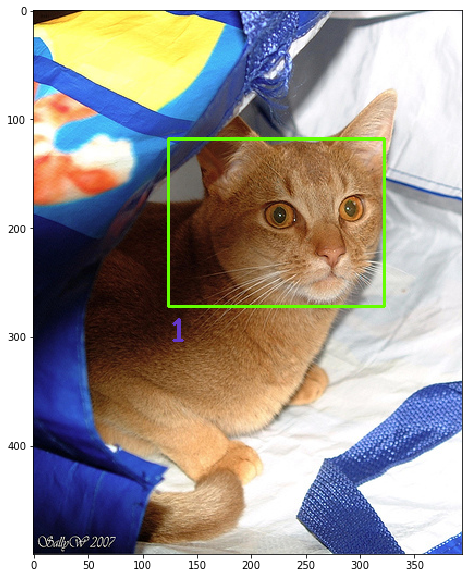

In [83]:
image = cv2.imread('C:/Users/gorya/OneDrive/Desktop/TZ/cats_dogs_dataset/Abyssinian_100.jpg' )
start = time.time()
predict(image, 151, 71, 335, 267)
end = time.time()
print(f"time of one iteration tooks {(end-start)*1000} milliseconds")
print('Total Training Images: {}, Total Test Images: {}'.format(
    len(train_images), 
    len(val_images)
    ))